In [33]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
import warnings
import os
warnings.filterwarnings('ignore')

In [34]:
stock_symbol = 'FB' # Stock Symbol Google / Alphabet
# last 5 years data with interval 1 day
data = yf.download(tickers=stock_symbol, period='10y', interval='1d')
s = pd.Series(list(range(0, len(data))))
data.set_index(s, inplace=True)
data_training_size = int(len(data)*0.7)
data_test_size = len(data) - data_training_size
data_training, data_test = data.iloc[0:data_training_size,:], data.iloc[data_training_size:len(data),:]
data_training = data_training.drop(['Adj Close'], axis=1)
data_test = data_test.drop(['Adj Close'], axis=1)
sc = MinMaxScaler()
training_data = sc.fit_transform(data_training)
training_data

[*********************100%***********************]  1 of 1 completed


array([[0.12128111, 0.13341652, 0.10395486, 0.10261801, 1.        ],
       [0.09335154, 0.09178937, 0.07853803, 0.08159383, 0.28587298],
       [0.07351751, 0.07646618, 0.06806629, 0.06642639, 0.16889149],
       ...,
       [0.63180528, 0.63104567, 0.6289142 , 0.63322819, 0.02870152],
       [0.63246307, 0.6303469 , 0.62672831, 0.63307803, 0.01798936],
       [0.63281721, 0.63433992, 0.63552259, 0.63107575, 0.01232227]])

In [35]:
def create_gaf(timeseries):
    data = dict()
    gadf = GramianAngularField(method='difference', image_size=timeseries.shape[0])
    data['gadf'] = gadf.fit_transform(pd.DataFrame(timeseries).T)[0]
    return data['gadf']

In [36]:
window = 60# check that window is less than shape[0]
x_train = []
y_train = []
for i in range(window, training_data.shape[0]):
    # take from current minus 60 first dimension, empty seconds dimension to grab all 5
    x_train.append(training_data[i-window:i])
    y_train.append(training_data[i, 0]) # zero second dimension only to grab which result should be
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((1613, 60, 5), (1613,))

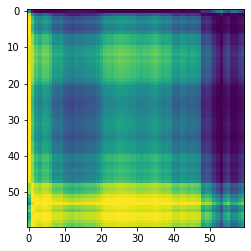

In [37]:
gadfImage = create_gaf(x_train[0]) # first image
plt.imshow(gadfImage, interpolation='nearest')
plt.show()

In [38]:
gadf_training = []
for i in x_train:
    gadf_training.append(create_gaf(i))
gadf_training = np.array(gadf_training)
gadf_training = gadf_training.reshape(-1, gadf_training.shape[1], gadf_training.shape[2], 1)
gadf_training.shape

(1613, 60, 60, 1)

In [78]:
# model = keras.models.Sequential([
#     keras.layers.Conv2D(60, kernel_size=(3, 3), activation='relu', input_shape=(60, 60, 1)),
#     keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(60, kernel_size=(3, 3), activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(60, kernel_size=(3, 3), strides=2, padding='same', activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(0.4),
#     # Second Convolution
#     keras.layers.Conv2D(120, kernel_size=(3, 3), activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(120, kernel_size=(3, 3), activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(120, kernel_size=(3, 3), strides=2, padding='same', activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(0.4),
#     # Third Convolution
#     keras.layers.Conv2D(240, kernel_size=4, activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Flatten(),
#     keras.layers.Dropout(0.4),
#     # Output layer
#     keras.layers.Dense(units=1)
# ])
# model.summary()


model = keras.models.Sequential([
    # CNN
    keras.layers.Conv2D(60, kernel_size=(3, 3), activation='relu', input_shape=(60, 60, 1)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Dropout(0.5),
    
    keras.layers.Conv2D(120, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Dropout(0.5),
    
    keras.layers.Conv2D(240, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Dropout(0.5),
    
    keras.layers.Conv2D(480, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Dropout(0.5),
    
#     keras.layers.Conv2D(240, kernel_size=(3, 3), activation='relu'),
#     keras.layers.MaxPooling2D((2,2)),
#     keras.layers.Dropout(0.5),
    
    # Dense
    keras.layers.Flatten(),
    keras.layers.Dense(960, activation='relu'),
    # Output layer
    keras.layers.Dense(units=1)
])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 58, 58, 60)        600       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 29, 29, 60)        0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 29, 29, 60)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 27, 27, 120)       64920     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 13, 13, 120)       0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 13, 13, 120)       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 11, 11, 240)     

In [80]:
model.compile(
    optimizer='adam', #already does a batch aproach, re listen the podcast to remember later
    # adam algorithm is stochastic gradient decent, using batch but different from SGD uses adam algorithm to optimize
    loss = 'mean_squared_error'
)
model.fit(gadf_training, y_train, epochs=100, batch_size=32)

Epoch 1/100
 1/51 [..............................] - ETA: 14s - loss: 0.0499

2021-11-17 03:49:26.170458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - 2s 39ms/step - loss: 0.0477
Epoch 2/100
51/51 [==============================] - 2s 37ms/step - loss: 0.0425
Epoch 3/100
51/51 [==============================] - 2s 37ms/step - loss: 0.0400
Epoch 4/100
51/51 [==============================] - 2s 37ms/step - loss: 0.0345
Epoch 5/100
51/51 [==============================] - 2s 37ms/step - loss: 0.0317
Epoch 6/100
51/51 [==============================] - 2s 38ms/step - loss: 0.0293
Epoch 7/100
51/51 [==============================] - 2s 42ms/step - loss: 0.0286
Epoch 8/100
51/51 [==============================] - 2s 38ms/step - loss: 0.0242
Epoch 9/100
51/51 [==============================] - 2s 40ms/step - loss: 0.0226
Epoch 10/100
51/51 [==============================] - 2s 38ms/step - loss: 0.0220
Epoch 11/100
51/51 [==============================] - 2s 40ms/step - loss: 0.0186
Epoch 12/100
51/51 [==============================] - 2s 38ms/step - loss: 0.0182
Epoch 13/100
51/51 [=================

In [81]:
past_window_days = data_training.tail(window)
df = past_window_days.append(data_test, ignore_index = True)
df

,Open,High,Low,Close,Volume
0,155.399994,159.460007,155.009995,158.779999,19180100
1,159.559998,160.490005,157.949997,159.419998,17592000
2,158.509995,158.660004,153.279999,154.919998,21675100
3,155.860001,157.350006,153.550003,154.050003,19761300
4,154.759995,157.339996,154.460007,154.779999,15424700
...,...,...,...,...,...
773,332.489990,333.190002,325.510010,327.640015,21872600
774,329.820007,332.459991,327.000000,327.739990,12376600
775,330.179993,341.859985,329.779999,340.890015,25387200
776,344.339996,353.649994,343.200012,347.559998,25076600


In [82]:
inputs = sc.transform(df) # we transfor the data into an array and then gather the window sizes with the prediction
inputs

array([[0.69479859, 0.7047168 , 0.69875962, 0.70606197, 0.02337125],
       [0.71584698, 0.70985779, 0.71370473, 0.70926565, 0.02057364],
       [0.71053427, 0.70072377, 0.68996541, 0.68673974, 0.02776646],
       ...,
       [1.57913373, 1.6151235 , 1.5871797 , 1.61766038, 0.03430572],
       [1.65077917, 1.67397056, 1.65539856, 1.65104869, 0.03375857],
       [1.64819867, 1.63903171, 1.64355423, 1.62802218, 0.02149337]])

In [83]:
x_test = []
y_test = []
for i in range(window, inputs.shape[0]):
    # take from current minus 60 first dimension, empty seconds dimension to grab all 5
    x_test.append(inputs[i-window:i])
    y_test.append(inputs[i, 0]) # zero second dimension only to grab which result should be
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

((718, 60, 5), (718,))

In [84]:
# transfor flattened data into gaf

gadf_test = []

for i in x_test:
    gadf_test.append(create_gaf(i))
gadf_test = np.array(gadf_test)
gadf_test = gadf_test.reshape(-1, gadf_test.shape[1], gadf_test.shape[2], 1)
gadf_test.shape

(718, 60, 60, 1)

In [85]:
y_pred = model.predict(gadf_test)
y_pred

2021-11-17 03:52:46.436415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


array([[0.5605812 ],
       [0.56964874],
       [0.5900787 ],
       [0.59136176],
       [0.41828823],
       [0.5607587 ],
       [0.55409956],
       [0.5556549 ],
       [0.43345407],
       [0.5288521 ],
       [0.57060003],
       [0.51774085],
       [0.39916682],
       [0.5179261 ],
       [0.5540235 ],
       [0.49336788],
       [0.50866854],
       [0.5358335 ],
       [0.55940056],
       [0.49641842],
       [0.42792955],
       [0.50904566],
       [0.49182877],
       [0.4997467 ],
       [0.47883558],
       [0.38602772],
       [0.4479892 ],
       [0.43132758],
       [0.4713103 ],
       [0.4126876 ],
       [0.5054487 ],
       [0.48018345],
       [0.4128303 ],
       [0.28693575],
       [0.18680237],
       [0.23134144],
       [0.28335997],
       [0.16683938],
       [0.13750657],
       [0.15048395],
       [0.12885194],
       [0.13319695],
       [0.12432715],
       [0.1511026 ],
       [0.13739204],
       [0.131365  ],
       [0.12335941],
       [0.126

In [86]:
# un scale the values to normal amount of google shares
scale = (1/sc.scale_[0]) # scaling label -> amount that use scaler to scale
# every single value of scale_ is the factor that was use for every single value in the scaler
# sc.scale_[0] is the scaler factor
# we do the 1/scale to do the reverse and have the original numbers
sc.scale_, sc.scale_[0], scale

(array([5.05970448e-03, 4.99126542e-03, 5.08336709e-03, 5.00575661e-03,
        1.76160763e-09]),
 0.00505970448005251,
 197.64000129699707)

In [87]:
y_pred_final = y_pred*scale
y_test_final = y_test*scale
# normal scales
y_test_final

array([123.92000008, 127.92999458, 130.92000008, 128.86999702,
       131.67000008, 131.11999702, 130.19999886, 126.55999947,
       129.3999958 , 129.97000313, 130.00999641, 128.1400013 ,
       147.52000618, 147.75999641, 147.61999702, 151.06999397,
       153.11999702, 150.11999702, 146.3900013 , 149.81999397,
       148.78000069, 147.30000496, 145.11000252, 146.42999458,
       142.42000008, 144.17000008, 143.84999275, 142.50000191,
       144.9900074 , 146.25999641, 144.81999397, 144.28999519,
       144.52000618, 145.81999397, 149.28999519, 154.81999397,
       153.42000008, 148.11999702, 153.52000618, 154.00999641,
       154.2400074 , 151.67999458, 149.08000374, 145.4900074 ,
       143.3999958 , 143.42000008, 146.80999947, 147.56999397,
       144.92000008, 149.27000618, 149.77000618, 146.4900074 ,
       148.30999947, 149.75000191, 152.05999947, 156.42000008,
       157.94000435, 158.80000496, 157.13000679, 157.53999519,
       160.09999275, 160.16000557, 159.92000008, 160.42

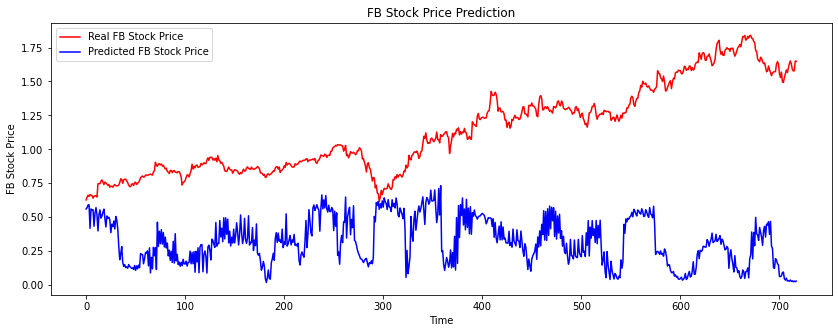

In [88]:
plt.figure(figsize=(14,5))
plt.plot(y_test, color='red', label='Real FB Stock Price')
plt.plot(y_pred, color='blue', label='Predicted FB Stock Price')
plt.title('FB Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('FB Stock Price')
plt.legend()
plt.show()

In [89]:
model.evaluate(gadf_test, y_test)

 9/23 [==========>...................] - ETA: 0s - loss: 0.3129

2021-11-17 03:52:49.356916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 0s 13ms/step - loss: 0.8211


0.8210952281951904